In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from plotting_utils import plotting_one_step_swsg
from swsg_ot_algorithm import SWSGDynamcis
import matplotlib as mpl
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt
import torch
import matplotlib.animation as animation
import pickle
from time import perf_counter_ns
from geomloss import SamplesLoss
from tqdm import tqdm

# My python classes for loops we've defined so far
from swsg_ot_algorithm import SWSGDynamcis
from unbalancedsinkhorn import UnbalancedOT, DebiasedUOT


In [2]:
! gpustat

nvidia6                     Wed Mar 12 11:37:25 2025  550.90.07
[0] NVIDIA GeForce RTX 3090 | 51°C,  75 % |  5711 / 24576 MB | zo122(368M) jz6422(5334M)
[1] NVIDIA GeForce RTX 3090 | 50°C,   0 % |   260 / 24576 MB | tw1320(254M)
[2] NVIDIA GeForce RTX 3090 | 54°C, 100 % | 21921 / 24576 MB | zo122(10622M) oz524(11290M)
[3] NVIDIA GeForce RTX 3090 | 29°C,   0 % |     3 / 24576 MB |
[4] NVIDIA GeForce RTX 3090 | 49°C, 100 % | 21998 / 24576 MB | oz524(21992M)
[5] NVIDIA GeForce RTX 3090 | 29°C,   0 % |     5 / 24576 MB |
[6] NVIDIA GeForce RTX 3090 | 52°C,  99 % | 11428 / 24576 MB | zo122(11422M)
[7] NVIDIA GeForce RTX 3090 | 50°C, 100 % | 14714 / 24576 MB | jz6422(14708M)


In [50]:
# parser.add_argument("method", type=str, help="method; one of 'euler' 'heun' 'rk4'")

cuda = 7
strength = 0.0001

In [ ]:
for i in range(7):
    epsilon = (1/25) * np.sqrt(2)**(-i)
    N = 1/ epsilon**2
    n = int(np.sqrt(N))
    dt = (1/25) * np.sqrt(2)**(-7)
    print('eps, N, sqrt(N): ', epsilon,  int(N), n)
i=7
epsilon = (1/25) * np.sqrt(2)**(-i)
N = 1/ epsilon**2
n = int(np.sqrt(N))
print('FINEST: eps, N, sqrt(N): ', epsilon, int(N), n)

    

In [4]:
def normal_pdf(x, y, mu_x, mu_y, sigma,alpha):
    """
    Calculate the PDF of a bivariate normal distribution.
    """
    # Constants
    sigma2 = torch.tensor([sigma**2])
    mu_x_ = torch.tensor([mu_x])
    mu_y_ = torch.tensor([mu_y])
    
    norm_factor = 1 / (2 * torch.pi * sigma2) #_x * sigma_y * torch.sqrt(1 - rho ** 2))   
    # Z computation
    z_x = (x - mu_x_) 
    z_y = (y - mu_y_) 
    
    z = z_x**2  + z_y ** 2 
    
    # PDF computation
    pdf = alpha*norm_factor * torch.exp(-0.5 * z/sigma2)
    pdfg0 = -alpha* z_x/sigma2 *norm_factor * torch.exp(-0.5 * z/sigma2)
    pdfg1 = -alpha* z_y/sigma2 *norm_factor * torch.exp(-0.5 * z/sigma2)
    
    return pdf.unsqueeze(-1), pdfg0  , pdfg1

def jet_profile_initialisation(epsilon, strength, f=1.0, g=0.1, a=0.1, b=10.0, c=0.5, d=1.0, pykeop=True):
    """
    Initialise a jet profile and associated object for solving the sWSG problem.
    """
    # Decide on parameters
    global n1, n2, m1, m2
    n1, n2 = int(1 / epsilon), int(1 / epsilon)
    m1, m2 = int(1 / epsilon), int(1 / epsilon)

    # Assigning uniform weighting to points - Lloyde type
    def height_func(x):
        return a * np.tanh(b * (x - c)) + d

    # integral of tanh is ln(cosh) so;
    def int_h(x):
        return a * np.log(np.cosh(b * (x - 0.5)) / np.cosh(-b * 0.5)) / b + d*x

    X_j = torch.linspace(1 / (2 * n1), 1 - 1 / (2 * n1), n1)

    # Calculate nabla P: x + f^2 * g * partial h
    G_i = X_j + f**-2 * g * a * b * (1 - np.tanh(b * (X_j - 0.5)) ** 2)

    # Tile the 1D into a 2D profile
    X = torch.cartesian_prod(
        torch.linspace(1 / (2 * m2), 1 - 1 / (2 * m2), m2),
        torch.linspace(1 / (2 * m1), 1 - 1 / (2 * m1), m1),
    )
    Y = torch.cartesian_prod(
        torch.linspace(1 / (2 * n2), 1 - 1 / (2 * n2), n2), torch.Tensor(X_j)
    )
    G = torch.cartesian_prod(
        torch.linspace(1 / (2 * n2), 1 - 1 / (2 * n2), n2), torch.Tensor(G_i)
    )

    h_true = height_func(X[:, 1]).view(-1, 1)
    mu = torch.ones_like(h_true) * d  / len(X[:, 1])

    no, no0 , no1  = normal_pdf(X[:,0],X[:,1],0.5,0.3,0.1,strength)  ## 0 is stationnary 
    h_true = h_true  + no 
    h_true = h_true.div(torch.sum(h_true)) 
    G = G + torch.stack((no0, no1), dim=1)

    return X, Y, G, h_true, mu

In [5]:
def Sinkhorn_Divergence_balanced(
    X,
    α,
    Y,
    β,
    dense_symmetric_potential=None,
    f0=None,
    g0=None,
    force_type="pykeops",
    tol=1e-9,
    epsilon=0.01,
    fullcompute=False
):
    """
    # Run OT(a, b) on grid X, Y reusing the dense symmeric potential and cost
    # dense_symmetric_potential = dict(f=g, uot(dense, dense))
    # a,X has to be dense
    """
    cuda = α.device
    uotclass = DebiasedUOT(pykeops=True, cuda_device=cuda)
    uotclass.parameters(epsilon=epsilon)
    uotclass.densities(X, Y, α, β)

    tic = perf_counter_ns()
    if dense_symmetric_potential is None and not fullcompute:

        f_update, g_update, i_sup = uotclass.sinkhorn_algorithm(
            tol=tol,
            verbose=False,
            aprox="balanced",
            convergence_repeats=3,
            convergence_or_fail=True,
        )

        d = uotclass.dual_cost(force_type=force_type)

        print("DENSE symmetric update final convergence:", f_update, g_update, i_sup)
        return dict(f=uotclass.g.view(-1, 1).cpu(), dual=sum(d))
    elif fullcompute:
        try:
            f_update, g_update, i_sup = uotclass.sinkhorn_algorithm(
                f0=f0, g0=g0, aprox="balanced", tol=tol, convergence_or_fail=True
            )
        except RuntimeWarning:
            f_update, g_update, i_sup = uotclass.sinkhorn_algorithm(
                f0=f0, g0=g0, aprox="balanced", tol=tol, convergence_or_fail=False, epsilon_annealing=True,
            )
        print("Sinkhorn full compute final convergence:", f_update, g_update, i_sup)
        s = uotclass.sinkhorn_divergence(tol=tol, force_type='pykeops', return_type='dual')
        return s.cpu().item(), uotclass
    else:


        f_update, g_update, i_sup = uotclass.sinkhorn_algorithm(
            f0=f0, g0=g0, aprox="balanced", tol=tol, convergence_or_fail=False,
        )

        print("Sinkhorn update final convergence:", f_update, g_update, i_sup)

        # solve the new symmetric potential problem
        uotclass.debias_g = UnbalancedOT(
            pykeops=uotclass.pykeops,
            debias=False,
            cuda_device=uotclass.device,
        )

        uotclass.debias_g.parameters(
            uotclass.epsilon, uotclass.rho, uotclass.cost_const
        )

        uotclass.debias_g.densities(
            uotclass.Y_t, uotclass.Y_t, uotclass.β_t, uotclass.β_t
        )
        
        # solve the new symmetric potential problem
        uotclass.debias_f = UnbalancedOT(
            pykeops=uotclass.pykeops,
            debias=False,
            cuda_device=uotclass.device,
        )

        uotclass.debias_f.parameters(
            uotclass.epsilon, uotclass.rho, uotclass.cost_const
        )

        uotclass.debias_f.densities(
            uotclass.X_s, uotclass.X_s, uotclass.α_s, uotclass.α_s
        )
        
        # load in known potential
        uotclass.debias_f.f = dense_symmetric_potential['f'].to(uotclass.α_s)
        uotclass.debias_f.g = dense_symmetric_potential['f'].to(uotclass.α_s)

        f_update, g_update, i_sup = uotclass.debias_g.sinkhorn_algorithm(
            tol=tol,
            verbose=False,
            left_divergence=uotclass.right_div.print_type(),
            right_divergence=uotclass.right_div.print_type(),
            convergence_repeats=3,
        )
        print("GGG update final convergence:", f_update, g_update, i_sup)

        f_update, g_update, i_sup = uotclass.debias_f.sinkhorn_algorithm(
            tol=tol,
            verbose=False,
            left_divergence=uotclass.right_div.print_type(),
            right_divergence=uotclass.right_div.print_type(),
            convergence_repeats=1,
        )
        toc = perf_counter_ns()

        print("FFFF update final convergence:", f_update, g_update, i_sup)
        print(f"W2 Computed in {toc-tic} ns")

        return (
            sum(uotclass.dual_cost(force_type=force_type))
            - (
                sum(uotclass.debias_f.dual_cost(force_type=force_type))
                + sum(uotclass.debias_g.dual_cost(force_type=force_type))
            )
            / 2
            + uotclass.epsilon * (uotclass.α_s.sum() - uotclass.β_t.sum()) ** 2 / 2
        ).cpu().item(), uotclass

In [6]:
global device
device = f'cuda:{cuda}'

In [7]:
# X_xy, Y, G_xy, h_true, mu = jet_profile_initialisation(epsilon, strength, f=1.0, g=0.1, a=0.1, b=10.0, c=0.5, d=1.0)


In [36]:
# Load in fine data
E = 1 / np.sqrt(200**2)
method = 'heun'

with open(f'data_store/simstudy_{method}_{E}_{E}_strength_{strength}.pkl', 'rb') as f:
    data_fine = pickle.load(f)
    
#     X, Y, G, h_true, mu
    
X_dense, _, _, sigma_weights_dense, _ = jet_profile_initialisation(E, strength, f=1.0, g=0.1, a=0.1, b=10.0, c=0.5, d=1.0)
sigma_weights_dense /= sigma_weights_dense.sum()

In [38]:
 data_fine[0].shape, data_course[0].shape

(torch.Size([40000, 2, 6000]), torch.Size([19881, 2, 4000]))

In [ ]:
# data_store/simstudy_finer_{method}_{E}_{E}_strength_{strength}_dense_potential0.01.pkl
# For dense potential of T20]

In [52]:
try:
    with open(f'data_store/simstudy_finer_{method}_{E}_{E}_strength_{strength}_dense_potential_T10.pkl', 'rb') as f:
        d = pickle.load(f)
except FileNotFoundError:
    # Compute and save the symmtric potential;
    d = Sinkhorn_Divergence_balanced(
        data_fine[0][:,:,2000-1].to(device),
        sigma_weights_dense.to(device),
        data_fine[0][:,:,2000-1].to(device),
        sigma_weights_dense.to(device),
        dense_symmetric_potential=None,
        f0=None,
        g0=None,
        force_type="pykeops",
        tol=1e-9,
        epsilon=0.01,
        fullcompute=False
    )

    print(d)

    with open(f'data_store/simstudy_finer_{method}_{E}_{E}_strength_{strength}_dense_potential_T10.pkl', 'wb') as f:
        pickle.dump(d,f)

Convergence in f, g updates below 1e-09 in 145 iterations
DENSE symmetric update final convergence: tensor(9.723778518488935e-10, device='cuda:7', dtype=torch.float64) tensor(9.336431757919761e-10, device='cuda:7', dtype=torch.float64) 145
{'f': tensor([[0.009473097038451],
        [0.009127078594531],
        [0.008797558162580],
        ...,
        [0.007521699475025],
        [0.007844570865538],
        [0.008182900701225]], dtype=torch.float64), 'dual': tensor(0.029257358762713, device='cuda:7', dtype=torch.float64)}


In [53]:
for N in [25**2, 35**2, 50**2, 71**2,100**2, 141**2]: #, 141**2, 200**2
    epsilon = 1/np.sqrt(N)
    dt = 1/np.sqrt(200**2)
    n = int(np.sqrt(N))
    dt = (1/25) * np.sqrt(2)**(-7)
    print('eps, N, sqrt(N): ', epsilon,  int(N), n)
N = 200**2
epsilon = 1/np.sqrt(N)
dt = 1/np.sqrt(200**2)
n = int(np.sqrt(N))
print('FINEST: eps, N, sqrt(N): ', epsilon, int(N), n)

    

eps, N, sqrt(N):  0.04 625 25
eps, N, sqrt(N):  0.02857142857142857 1225 35
eps, N, sqrt(N):  0.02 2500 50
eps, N, sqrt(N):  0.014084507042253521 5041 71
eps, N, sqrt(N):  0.01 10000 100
eps, N, sqrt(N):  0.0070921985815602835 19881 141
FINEST: eps, N, sqrt(N):  0.005 40000 200


In [54]:
# simstudy_shorter_heun_0.0035355339059327364_0.0049999999999999975_strength_0.0001.pkl
for N in [25**2, 35**2, 50**2, 71**2,100**2, 141**2]: #, 141**2, 200**2
    epsilon = 1/np.sqrt(N)
    dt = 1/np.sqrt(200**2)
    method = 'heun'
    
    # Load in course data
    with open(f'data_store/simstudy_finer_{method}_{dt}_{epsilon}_strength_{strength}.pkl', 'rb') as f:
        data_course = pickle.load(f)
        
    print(data_course[0].shape, data_fine[0].shape)

torch.Size([625, 2, 4000]) torch.Size([40000, 2, 6000])
torch.Size([1225, 2, 4000]) torch.Size([40000, 2, 6000])
torch.Size([2500, 2, 4000]) torch.Size([40000, 2, 6000])
torch.Size([5041, 2, 4000]) torch.Size([40000, 2, 6000])
torch.Size([10000, 2, 4000]) torch.Size([40000, 2, 6000])
torch.Size([19881, 2, 4000]) torch.Size([40000, 2, 6000])


In [ ]:
s = []
for N in [25**2, 35**2, 50**2, 71**2,100**2, 141**2]: #, 141**2, 200**2
    epsilon = 1/np.sqrt(N)
    dt = 1/np.sqrt(200**2)
    method = 'heun'
    
    # Load in course data
    with open(f'data_store/simstudy_finer_{method}_{dt}_{epsilon}_strength_{strength}.pkl', 'rb') as f:
        data_course = pickle.load(f)

    _, _, _, sigma_weights, _ = jet_profile_initialisation(epsilon, strength, f=1.0, g=0.1, a=0.1, b=10.0, c=0.5, d=1.0)

    sigma_weights /= sigma_weights.sum()
    
    tic = perf_counter_ns()
    output, uotclass = Sinkhorn_Divergence_balanced(
            data_fine[0][:,:,2000-1].to(device),
            sigma_weights_dense.to(device),
            data_course[0][:, :, 2000-1].to(device),
            sigma_weights.to(device),
            dense_symmetric_potential=d,
            force_type="pykeops",
            tol=1e-10,
            epsilon=0.01,
            fullcompute=False
        )  
    toc = perf_counter_ns()

    print('TIMING: ', tic-toc, output)
    s.append(output)
    
    with open('finer_save_T10.pkl', 'wb') as f:
        pickle.dump(s, f)
    

Sinkhorn update final convergence: tensor(1.077241934543949e-09, device='cuda:7', dtype=torch.float64) tensor(1.077241926737693e-09, device='cuda:7', dtype=torch.float64) 371
Convergence in f, g updates below 1e-10 in 174 iterations
GGG update final convergence: tensor(9.270967327168478e-11, device='cuda:7', dtype=torch.float64) tensor(8.902889970380246e-11, device='cuda:7', dtype=torch.float64) 174
Convergence in f, g updates below 1e-10 in 27 iterations
FFFF update final convergence: tensor(9.985121063316171e-11, device='cuda:7', dtype=torch.float64) tensor(9.587469446820096e-11, device='cuda:7', dtype=torch.float64) 27
W2 Computed in 264428164578 ns
TIMING:  -266394251134 8.7846499546078e-06
Sinkhorn update final convergence: tensor(1.156986416395167e-09, device='cuda:7', dtype=torch.float64) tensor(1.156986413359401e-09, device='cuda:7', dtype=torch.float64) 391
Convergence in f, g updates below 1e-10 in 174 iterations
GGG update final convergence: tensor(9.411173923501437e-11, dev

Text(0, 0.5, '$\\sqrt{S_{\\epsilon}}$')

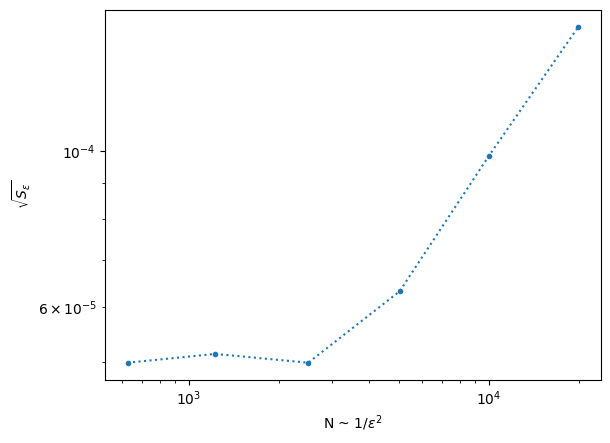

In [21]:
plt.loglog([25**2, 35**2, 50**2, 71**2,100**2, 141**2], [t for t in s], ':.')
plt.xlabel(r'N ~ 1/$\varepsilon^2$')
plt.ylabel('$\sqrt{S_{\epsilon}}$')

In [14]:
np.polyfit([np.log(k) for k in [71,100, 141,]], [np.log(np.sqrt(t)) for t in s][2:-1], deg=1)

array([ 0.49452387, -7.0777635 ])

In [47]:
assert(0)

AssertionError: 

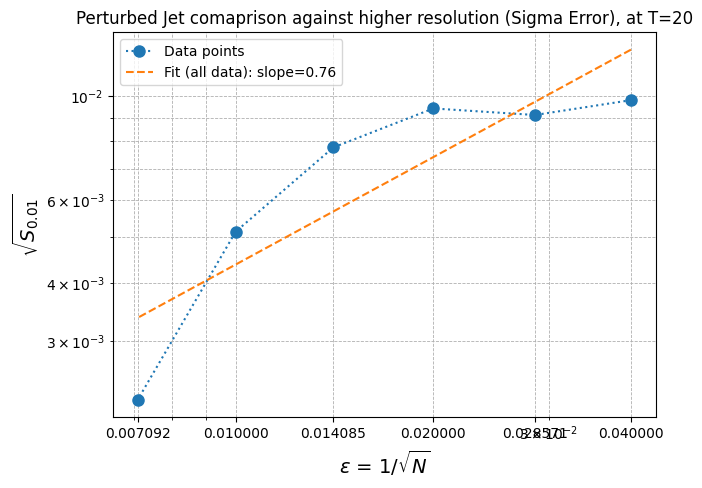

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Given data
epsilons = np.sqrt(1 / np.array([25**2, 35**2, 50**2, 71**2, 100**2, 141**2]))
s_values = np.array(s)  # Assuming 's' is defined elsewhere
filtered_s = np.where(s_values > 1e-14, s_values, 0)  # Replace values below threshold with 0
sqrt_s = np.sqrt(filtered_s)

# Log-log plot
plt.figure(figsize=(7, 5))
plt.loglog(epsilons, sqrt_s, 'o:', label='Data points', markersize=8)

# Polyfit for all data
coeffs_all = np.polyfit(np.log(epsilons), np.log(sqrt_s), 1)
fit_all = np.exp(coeffs_all[1]) * epsilons**coeffs_all[0]
plt.loglog(epsilons, fit_all, '--', label=f'Fit (all data): slope={coeffs_all[0]:.2f}')

# Polyfit for central points (excluding first and last)
central_eps = epsilons[2:]
central_sqrt_s = sqrt_s[2:]
coeffs_central = np.polyfit(np.log(central_eps), np.log(central_sqrt_s), 1)
fit_central = np.exp(coeffs_central[1]) * central_eps**coeffs_central[0]
# plt.loglog(central_eps, fit_central, '-.', label=f'Fit (central points): slope={coeffs_central[0]:.2f}')

plt.xticks(epsilons, [f"{eps:.6f}" for eps in epsilons])

# Labels and formatting
plt.title('Perturbed Jet comaprison against higher resolution (Sigma Error), at T=20')
plt.xlabel(r'$\varepsilon$ = 1/$\sqrt{N}$', fontsize=14)
plt.ylabel(r'$\sqrt{S_{0.01}}$', fontsize=14)
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.6)
plt.show()


ValueError: Format 'pfd' is not supported (supported formats: eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff, webp)

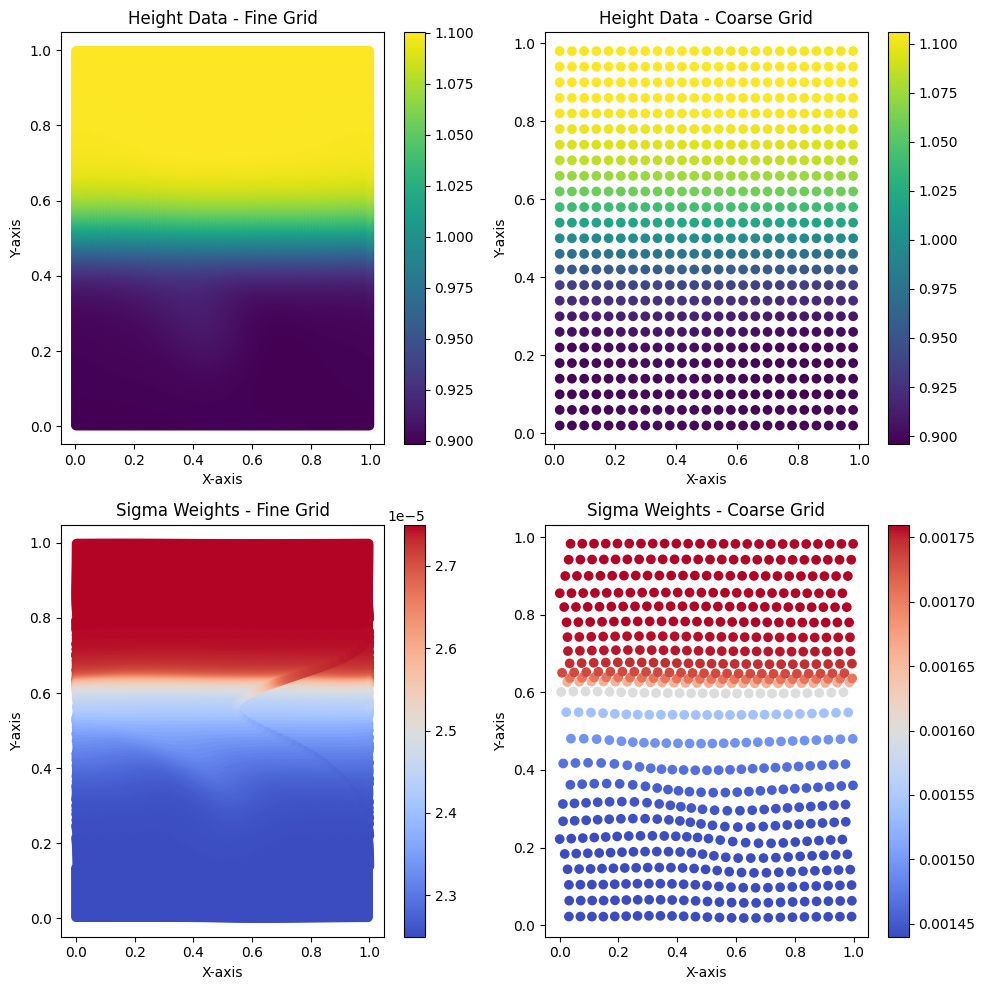

In [22]:
import numpy as np
import matplotlib.pyplot as plt
shift = 2000


for N in [25**2, 35**2, 50**2, 71**2,100**2, 141**2]: #, 141**2, 200**2
    epsilon = 1/np.sqrt(N)
    dt = 1/np.sqrt(200**2)
    method = 'heun'

    # Load in course data
    with open(f'data_store/simstudy_finer_{method}_{dt}_{epsilon}_strength_{strength}.pkl', 'rb') as f:
        data_course = pickle.load(f)

    X, _, _, sigma_weights, _ = jet_profile_initialisation(epsilon, strength, f=1.0, g=0.1, a=0.1, b=10.0, c=0.5, d=1.0)


    fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # 2x2 grid

    # First scatter plot
    sc = axes[0, 0].scatter(X_dense[:, 0], X_dense[:, 1], c=data_fine[1][:, :, 4000-1-shift], cmap='viridis')
    axes[0, 0].set_title('Height Data - Fine Grid')
    fig.colorbar(sc, ax=axes[0, 0])

    # Second scatter plot
    sc = axes[0, 1].scatter(X[:, 0], X[:, 1], c=data_course[1][:, :, 4000-1-shift], cmap='viridis')
    axes[0, 1].set_title('Height Data - Coarse Grid')
    fig.colorbar(sc, ax=axes[0, 1])

    # Third scatter plot
    sc = axes[1, 0].scatter(data_fine[0][:, 0, 4000-1-shift], data_fine[0][:, 1, 4000-1-shift], c=sigma_weights_dense, cmap='coolwarm')
    axes[1, 0].set_title('Sigma Weights - Fine Grid')
    fig.colorbar(sc, ax=axes[1, 0])

    # Fourth scatter plot
    sc = axes[1, 1].scatter(data_course[0][:, 0, 4000-1-shift], data_course[0][:, 1, 4000-1-shift], c=sigma_weights, cmap='coolwarm')
    axes[1, 1].set_title('Sigma Weights - Coarse Grid')
    fig.colorbar(sc, ax=axes[1, 1])

    # Formatting
    for ax in axes.flat:
        ax.set_xlabel('X-axis')
        ax.set_ylabel('Y-axis')

    plt.tight_layout()
    plt.savefig(f'course_vs_fine_fig_N{N}.pfd')


## Height

In [32]:
try:
    with open(f'data_store/simstudy_fine_{method}_{E}_{E}_strength_{strength}_dense_potential_height_T5.pkl', 'rb') as f:
        d = pickle.load(f)
except FileNotFoundError:
    # Compute and save the symmtric potential;
    d = Sinkhorn_Divergence_balanced(
        X_dense.to(device),
        data_fine[1][:,:,1000-1].to(device),
        X_dense.to(device),
        data_fine[1][:,:,1000-1].to(device),
        dense_symmetric_potential=None,
        f0=None,
        g0=None,
        force_type="pykeops",
        tol=1e-9,
        epsilon=0.01,
        fullcompute=False
    )

    print(d)

    with open(f'data_store/simstudy_fine_{method}_{E}_{E}_strength_{strength}_dense_potential_height_T5.pkl', 'wb') as f:
        pickle.dump(d,f)

Convergence in f, g updates below 1e-09 in 112 iterations
DENSE symmetric update final convergence: tensor(9.255382571460302e-10, device='cuda:7', dtype=torch.float64) tensor(8.805988299664946e-10, device='cuda:7', dtype=torch.float64) 112
{'f': tensor([[0.009274370322344],
        [0.008932554633094],
        [0.008606711757126],
        ...,
        [0.007599757713077],
        [0.007925494284179],
        [0.008267205607217]], dtype=torch.float64), 'dual': tensor(15996545.091005833819509, device='cuda:7', dtype=torch.float64)}


In [33]:
s1 = []
for N in [25**2, 35**2, 50**2, 71**2,100**2,141**2]: #, 141**2, 200**2
    epsilon = 1/np.sqrt(N)
    dt = 1/np.sqrt(200**2)
    method = 'heun'
    
    # Load in course data
    with open(f'data_store/simstudy_finer_{method}_{dt}_{epsilon}_strength_{strength}.pkl', 'rb') as f:
        data_course = pickle.load(f)

    X, _, _, sigma_weights, _ = jet_profile_initialisation(epsilon, strength, f=1.0, g=0.1, a=0.1, b=10.0, c=0.5, d=1.0)

    sigma_weights /= sigma_weights.sum()
 
    tic = perf_counter_ns()
    output, uotclass = Sinkhorn_Divergence_balanced(
            X_dense.to(device),
            data_fine[1][:,:,1000-1].to(device).view(-1,1),
            X,
            data_course[1][:, :, 1000-1].to(device).view(-1,1),
            dense_symmetric_potential=d,
            force_type="pykeops",
            tol=1e-10,
            epsilon=0.01,
            fullcompute=False
        )  
    toc = perf_counter_ns()
    
    s1.append(output)
    with open('fixed_eps_data_T5.pkl', 'wb') as f:
        pickle.dump(s, f)
#  Look at solutions

Sinkhorn update final convergence: tensor(0.041588829753303, device='cuda:7', dtype=torch.float64) tensor(0.041588829753303, device='cuda:7', dtype=torch.float64) 246
Convergence in f, g updates below 1e-10 in 134 iterations
GGG update final convergence: tensor(9.995523506112214e-11, device='cuda:7', dtype=torch.float64) tensor(9.510369835402654e-11, device='cuda:7', dtype=torch.float64) 134
Convergence in f, g updates below 1e-10 in 22 iterations
FFFF update final convergence: tensor(9.384498733666646e-11, device='cuda:7', dtype=torch.float64) tensor(8.929141800950724e-11, device='cuda:7', dtype=torch.float64) 22
W2 Computed in 43226848611 ns
Sinkhorn update final convergence: tensor(0.034859385188588, device='cuda:7', dtype=torch.float64) tensor(0.034859385188586, device='cuda:7', dtype=torch.float64) 242
Convergence in f, g updates below 1e-10 in 135 iterations
GGG update final convergence: tensor(9.344600787608570e-11, device='cuda:7', dtype=torch.float64) tensor(8.891652778647563e

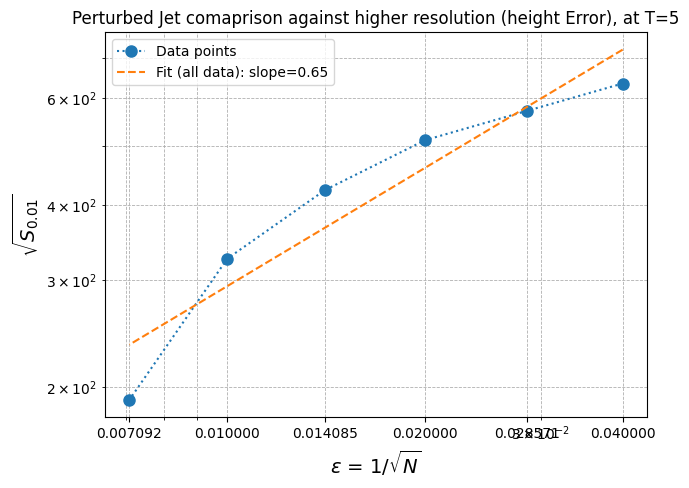

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Given data
epsilons = np.sqrt(1 / np.array([25**2, 35**2, 50**2, 71**2, 100**2, 141**2]))
s_values = np.array(s1)  # Assuming 's' is defined elsewhere
filtered_s = np.where(s_values > 1e-14, s_values, 0)  # Replace values below threshold with 0
sqrt_s = np.sqrt(filtered_s)

# Log-log plot
plt.figure(figsize=(7, 5))
plt.loglog(epsilons, sqrt_s, 'o:', label='Data points', markersize=8)

# Polyfit for all data
coeffs_all = np.polyfit(np.log(epsilons), np.log(sqrt_s), 1)
fit_all = np.exp(coeffs_all[1]) * epsilons**coeffs_all[0]
plt.loglog(epsilons, fit_all, '--', label=f'Fit (all data): slope={coeffs_all[0]:.2f}')

# Polyfit for central points (excluding first and last)
central_eps = epsilons[2:]
central_sqrt_s = sqrt_s[2:]
coeffs_central = np.polyfit(np.log(central_eps), np.log(central_sqrt_s), 1)
fit_central = np.exp(coeffs_central[1]) * central_eps**coeffs_central[0]
# plt.loglog(central_eps, fit_central, '-.', label=f'Fit (central points): slope={coeffs_central[0]:.2f}')

plt.xticks(epsilons, [f"{eps:.6f}" for eps in epsilons])

# Labels and formatting
plt.title('Perturbed Jet comaprison against higher resolution (height Error), at T=5')
plt.xlabel(r'$\varepsilon$ = 1/$\sqrt{N}$', fontsize=14)
plt.ylabel(r'$\sqrt{S_{0.01}}$', fontsize=14)
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.6)
plt.show()


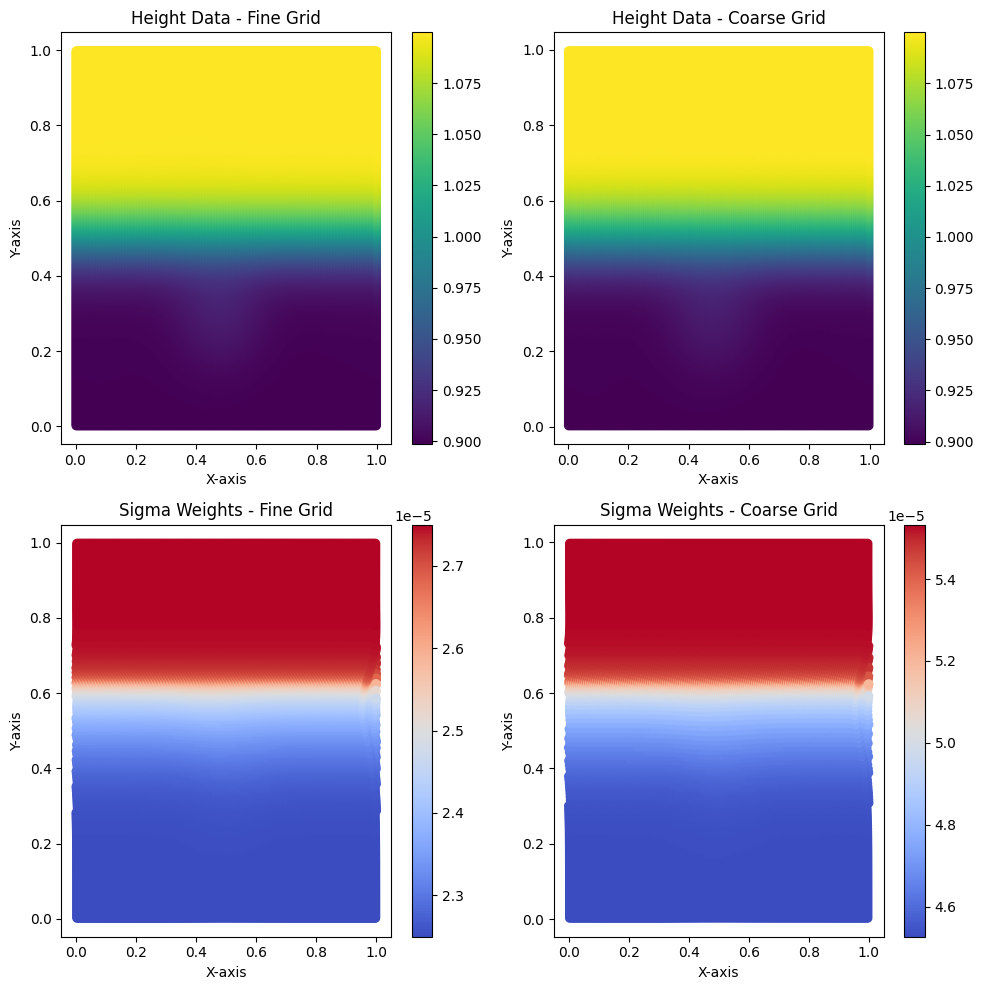

In [13]:
import numpy as np
import matplotlib.pyplot as plt
shift = 3000


N = 141**2
epsilon = 1/np.sqrt(N)
dt = 1/np.sqrt(200**2)
method = 'heun'

# Load in course data
with open(f'data_store/simstudy_finer_{method}_{dt}_{epsilon}_strength_{strength}.pkl', 'rb') as f:
    data_course = pickle.load(f)

X, _, _, sigma_weights, _ = jet_profile_initialisation(epsilon, strength, f=1.0, g=0.1, a=0.1, b=10.0, c=0.5, d=1.0)


fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # 2x2 grid

# First scatter plot
sc = axes[0, 0].scatter(X_dense[:, 0], X_dense[:, 1], c=data_fine[1][:, :, 4000-1-shift], cmap='viridis')
axes[0, 0].set_title('Height Data - Fine Grid')
fig.colorbar(sc, ax=axes[0, 0])

# Second scatter plot
sc = axes[0, 1].scatter(X[:, 0], X[:, 1], c=data_course[1][:, :, 4000-1-shift], cmap='viridis')
axes[0, 1].set_title('Height Data - Coarse Grid')
fig.colorbar(sc, ax=axes[0, 1])

# Third scatter plot
sc = axes[1, 0].scatter(data_fine[0][:, 0, 4000-1-shift], data_fine[0][:, 1, 4000-1-shift], c=sigma_weights_dense, cmap='coolwarm')
axes[1, 0].set_title('Sigma Weights - Fine Grid')
fig.colorbar(sc, ax=axes[1, 0])

# Fourth scatter plot
sc = axes[1, 1].scatter(data_course[0][:, 0, 4000-1-shift], data_course[0][:, 1, 4000-1-shift], c=sigma_weights, cmap='coolwarm')
axes[1, 1].set_title('Sigma Weights - Coarse Grid')
fig.colorbar(sc, ax=axes[1, 1])

# Formatting
for ax in axes.flat:
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')

plt.tight_layout()
plt.show()


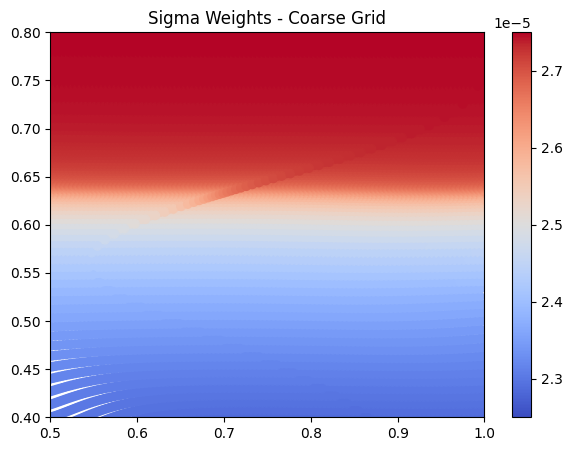

In [23]:
# Fourth scatter plot
shift = 3000

fig = plt.figure(figsize=(7,5))
sc = plt.scatter(data_fine[0][:, 0, 4000-1-shift], data_fine[0][:, 1, 4000-1-shift], c=sigma_weights_dense, cmap='coolwarm')
plt.xlim([0.5, 1.0])
plt.ylim([0.4, 0.8])

plt.title('Sigma Weights - Coarse Grid')
plt.colorbar(sc)

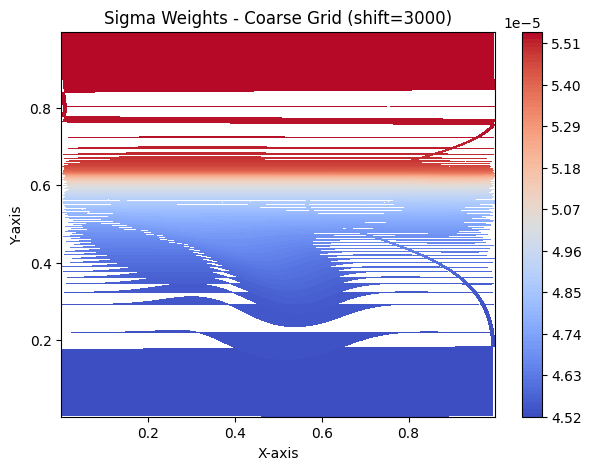

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Set shift
shift = 3000

# Reshape X, Y, and sigma_weights to (N, M)
N, M = 141, 141  # Assuming a 141x141 grid
X = data_course[0][:, 0, 4000-1-shift].numpy().reshape(N, M, order='F')
Y = data_course[0][:, 1, 4000-1-shift].numpy().reshape(N, M, order='F')
Z = sigma_weights.numpy().reshape(N, M, order='F')  # Reshape sigma_weights to match

# Create figure
fig, ax = plt.subplots(figsize=(7, 5))

# Contour plot (filled)
contour = ax.contourf(X, Y, Z, cmap='coolwarm', levels=100)  # Adjust `levels` for smoothness
cbar = plt.colorbar(contour, ax=ax)

# Labels and title
ax.set_title(f'Sigma Weights - Coarse Grid (shift={shift})')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

plt.show()
